- [x] dim user (rfm segment) for checkout flow
- seems there is no relationship between user flag and checkout page changes
- [x] rate reverse flow
- [ ] rate unfinished checkout
- [x] time spent for each page
    - [ ] change add/remove item, add/remove shipment, time scope change
- [ ] drop vs go to prev page
- [ ] cat, price, quantity dim for reverse flow
    - [x] dim app/web
- [ ] ga -> page bounce rate
- [ ] see data for longer time, maybe a week
- [x] decorator get from db cache

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from db import DB

In [5]:
db = DB()

In [6]:
start_date = '2023-09-08 00:00:00'
funnel_steps_logs = db.get_funnel_steps_log(start_date)
user_data = db.get_user_data(start_date)
cart_data = db.get_cart_data(start_date)

## checkout flow

In [7]:
df2 = funnel_steps_logs.groupby('cart_id')['funnel_step'].apply(lambda x: '->'.join(x)).reset_index()
df2 = df2.groupby('funnel_step').count().reset_index()
df2.rename(columns={'cart_id': "count"}, inplace=True)
df2.sort_values(by="count", ascending=False, inplace=True)
df2["number_of_steps"] = df2["funnel_step"].apply(lambda x: len(x.split("->")))
df2['percentage'] = df2['count'] / df2['count'].sum() * 100

In [8]:
df2.head(30)

,funnel_step,count,number_of_steps,percentage
0,"""cart""",87180,1,45.716024
819,"""cart""->""shipping""->""payment""->""checkout""",18401,4,9.649238
2070,"""shipping""->""payment""->""checkout""",15322,3,8.034651
1169,"""shipping""",8862,1,4.647114
1170,"""shipping""->""cart""",7314,2,3.835364
65,"""cart""->""shipping""",6394,2,3.352928
66,"""cart""->""shipping""->""cart""",4959,3,2.600433
1727,"""shipping""->""cart""->""shipping""->""payment""->""ch...",4881,5,2.559531
504,"""cart""->""shipping""->""cart""->""shipping""->""payme...",3582,6,1.878353
1225,"""shipping""->""cart""->""shipping""",1854,3,0.972213


## checkout page changes

In [11]:
df3 = funnel_steps_logs.copy()
df3['previous_step'] = df3.groupby('cart_id')['funnel_step'].shift(1)
df3.dropna(inplace=True)
df3['funnel_step_change'] = df3['previous_step'] + '->' + df3['funnel_step']

In [10]:
df4 = df3.copy()
df4 = df4.groupby(by='funnel_step_change').count().reset_index()[['funnel_step_change', 'cart_id']]
df4.rename(columns={'cart_id': 'count'}, inplace=True)
df4.sort_values(by='count', ascending=False, inplace=True)
df4['percentage'] = df4['count'] / df4['count'].sum() * 100

In [11]:
df4

,funnel_step_change,count,percentage
3,"""cart""->""shipping""",1213227,33.715341
14,"""shipping""->""payment""",801289,22.267665
12,"""shipping""->""cart""",768922,21.368192
9,"""payment""->""checkout""",548672,15.247488
8,"""payment""->""cart""",134110,3.726891
11,"""payment""->""shipping""",102490,2.848177
15,"""shipping""->""shipping""",10290,0.285957
0,"""cart""->""cart""",9286,0.258056
2,"""cart""->""payment""",7042,0.195696
13,"""shipping""->""checkout""",1176,0.032681


In [12]:
df7 = df3.copy()
df7.rename(columns={"previous_step": "cur_page", "funnel_step": "next_page"}, inplace=True)
grouped_df7 = df7.groupby(["cur_page", "next_page"])['cart_id'].count().reset_index()
grouped_df7.rename(columns={"cart_id": "count"}, inplace=True)
grouped_df7.sort_values(by=['cur_page', 'next_page', 'count'], ascending=False, inplace=True)
grouped_df7['percentage'] = grouped_df7['count'] / grouped_df7.groupby('cur_page')['count'].transform('sum') * 100

In [13]:
grouped_df7.pivot(index='cur_page', columns='next_page', values='percentage').fillna(0)

next_page,"""cart""","""checkout""","""payment""","""shipping"""
cur_page,,,,
"""cart""",0.754674,0.073956,0.572304,98.599066
"""checkout""",2.849003,2.564103,83.333333,11.253561
"""payment""",17.071072,69.841318,0.041497,13.046113
"""shipping""",48.614350,0.074351,50.660723,0.650575


## adding dimensions to check out page changes

In [14]:
df5 = pd.merge(left=df3, right=user_data, how='inner', on='cart_id')
df5 = df5.groupby(by=['funnel_step_change', 'user_category']).count().reset_index()[
    ['user_category', 'funnel_step_change', 'cart_id']]
df5.rename(columns={'cart_id': 'count'}, inplace=True)
df5.sort_values(by=['user_category', 'count'], ascending=False, inplace=True)
df5['percentage'] = df5['count'] / df5.groupby('user_category')['count'].transform('sum') * 100

In [15]:
df5.pivot(index='funnel_step_change', columns='user_category', values='percentage').fillna(0)

user_category,About To Sleep,At Risk,Cannot Lose Them,Champion,Hibernating,Lost Customers,Loyal,Need Attention,New Customers\r\n,Potential Loyalist,Promising
funnel_step_change,,,,,,,,,,,
"""cart""->""cart""",0.343083,0.218559,0.198969,0.143759,0.298655,0.445167,0.146605,0.231607,0.284060,0.210907,0.181292
"""cart""->""checkout""",0.000000,0.036925,0.022284,0.024333,0.012985,0.002368,0.026237,0.009047,0.008740,0.014545,0.003181
"""cart""->""payment""",0.145810,0.181633,0.167134,0.129774,0.233730,0.254945,0.138219,0.165563,0.181361,0.168483,0.151077
"""cart""->""shipping""",37.704777,37.966308,38.448682,37.593135,38.471340,38.900027,38.262709,38.301125,37.773408,38.518321,38.239878
"""checkout""->""cart""",0.000000,0.000998,0.000000,0.000559,0.000812,0.000000,0.000000,0.000000,0.000000,0.001212,0.000000
"""checkout""->""checkout""",0.000000,0.000000,0.001592,0.000000,0.000812,0.000000,0.000541,0.001809,0.000000,0.001212,0.000000
"""checkout""->""payment""",0.008577,0.095806,0.031835,0.066006,0.006493,0.006314,0.018123,0.008142,0.006555,0.009697,0.011132
"""checkout""->""shipping""",0.008577,0.001996,0.001592,0.001678,0.002435,0.001579,0.001352,0.000905,0.000000,0.002424,0.000000
"""payment""->""cart""",3.670984,3.529870,3.570292,3.522643,3.405319,2.991460,3.557189,3.593529,4.042390,3.373292,3.469991


## time spend on each page

In [7]:
df6 = funnel_steps_logs.copy()
df6['page'] = df6.groupby('cart_id')['funnel_step'].shift(1)
df6['prev_changed_at'] = df6.groupby('cart_id')['changed_at'].shift(1)
df6.dropna(inplace=True)
df6['minutes_spent'] = (df6['changed_at'] - df6['prev_changed_at']).dt.total_seconds() / 60

<Axes: ylabel='Frequency'>

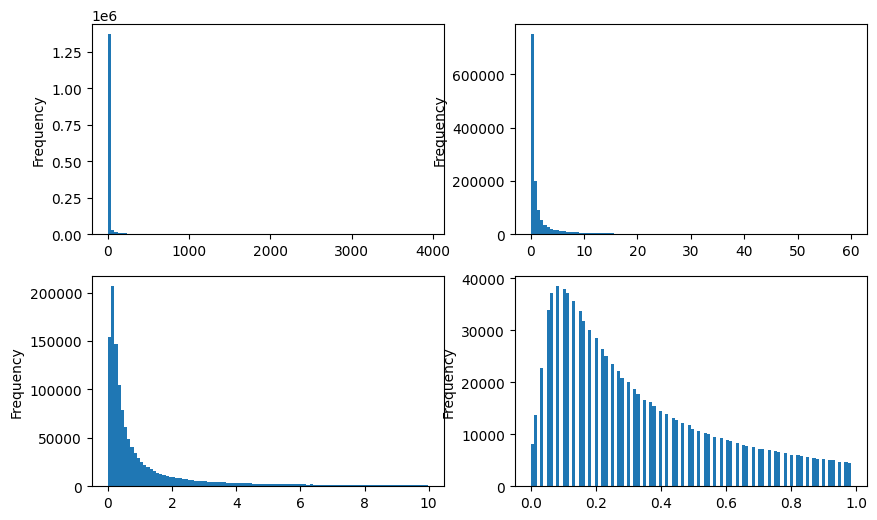

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
df6['minutes_spent'].plot(kind='hist', bins=100, ax=axs[0][0])
df6[df6['minutes_spent'] < 60]['minutes_spent'].plot(kind='hist', bins=100, ax=axs[0][1])
df6[df6['minutes_spent'] < 10]['minutes_spent'].plot(kind='hist', bins=100, ax=axs[1][0])
df6[df6['minutes_spent'] < 1]['minutes_spent'].plot(kind='hist', bins=100, ax=axs[1][1])

<AxesSubplot: ylabel='Frequency'>

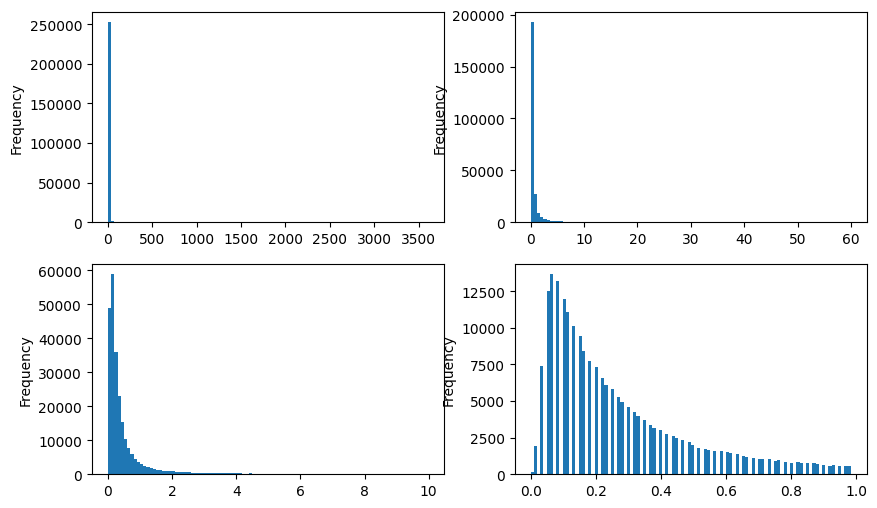

In [18]:
page = '"payment"'
fig4, axs = plt.subplots(2, 2, figsize=(10, 6))
df6[df6['page'] == page]['minutes_spent'].plot(kind='hist', bins=100, ax=axs[0][0])
df6[(df6['minutes_spent'] < 60) & (df6['page'] == page)]['minutes_spent'].plot(kind='hist', bins=100, ax=axs[0][1])
df6[(df6['minutes_spent'] < 10) & (df6['page'] == page)]['minutes_spent'].plot(kind='hist', bins=100, ax=axs[1][0])
df6[(df6['minutes_spent'] < 1) & (df6['page'] == page)]['minutes_spent'].plot(kind='hist', bins=100, ax=axs[1][1])

In [20]:
df6[df6['minutes_spent'] < 1].count() / df6.count()  # 67%
df6[df6['minutes_spent'] < 5].count() / df6.count()  # 84%
df6[df6['minutes_spent'] < 10].count() / df6.count()  # 88%
df6[df6['minutes_spent'] < 60].count() / df6.count()  # 94%

cart_id            0.882716
changed_at         0.882716
funnel_step        0.882716
page               0.882716
prev_changed_at    0.882716
minutes_spent      0.882716
dtype: float64

In [13]:
def time_flag(minute: float) -> str:
    if minute <= 1:
        return 'less than a minute'
    if minute <= 5:
        return 'between 1 and 5 minutes'
    return 'more than 5 minutes'


df6['time_flag'] = df6['minutes_spent'].apply(lambda x: time_flag(x))
df6.rename(columns={"funnel_step": "target_page"}, inplace=True)

In [19]:
grouped_df6 = df6.groupby(["page", "time_flag", "target_page"])['cart_id'].count().reset_index()
grouped_df6.rename(columns={"cart_id": "count"}, inplace=True)
grouped_df6.sort_values(by=['page', 'target_page', 'count'], ascending=False, inplace=True)
grouped_df6['percentage'] = grouped_df6['count'] / grouped_df6.groupby('page')['count'].transform('sum') * 100

In [20]:
grouped_df6.pivot(index=['page', 'target_page'], columns='time_flag', values='percentage').fillna(0)

time_flag               between 1 and 5 minutes  less than a minute  \
page       target_page                                                
"cart"     "cart"                      0.088909            0.556619   
           "checkout"                  0.020886            0.034784   
           "payment"                   0.130357            0.372542   
           "shipping"                 17.418537           44.423937   
"checkout" "cart"                      0.000000            1.282051   
           "checkout"                  0.000000            2.564103   
           "payment"                  10.826211           72.507123   
           "shipping"                  0.000000           11.253561   
"payment"  "cart"                      3.142447            5.697061   
           "checkout"                  4.965899           64.170097   
           "payment"                   0.007892            0.032841   
           "shipping"                  3.431908            8.128585   
"shipping" "cart"                     10.598371           21.049241   
           "checkout"                  0.007713            0.063224   
           "payment"                  12.318950           35.513572   
           "shipping"                  0.151611            0.419175   

time_flag               more than 5 minutes  
page       target_page                       
"cart"     "cart"                  0.109146  
           "checkout"              0.018286  
           "payment"               0.069405  
           "shipping"             36.756592  
"checkout" "cart"                  1.566952  
           "checkout"              0.000000  
           "payment"               0.000000  
           "shipping"              0.000000  
"payment"  "cart"                  8.231564  
           "checkout"              0.705323  
           "payment"               0.000764  
           "shipping"              1.485620  
"shipping" "cart"                 16.966738  
           "checkout"              0.003414  
           "payment"               2.828201  
           "shipping"              0.079789

## web vs app

<Axes: ylabel='count'>

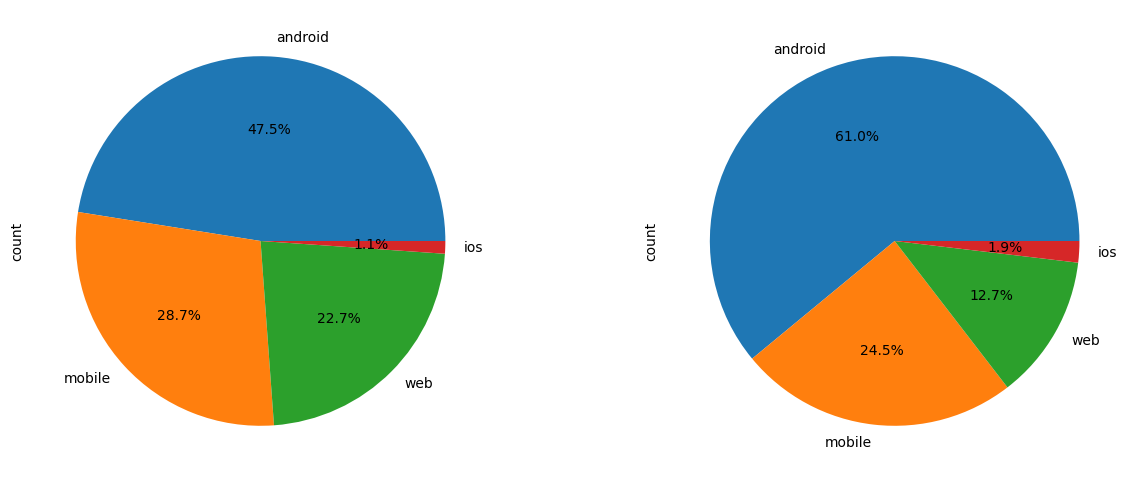

In [21]:
fig2, axs = plt.subplots(1, 2, figsize=(15, 6))
source = cart_data['source'].value_counts()
source.plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
source_close = cart_data['source_close'].value_counts()
source_close.plot(kind='pie', autopct='%1.1f%%', ax=axs[1])

<AxesSubplot: ylabel='Frequency'>

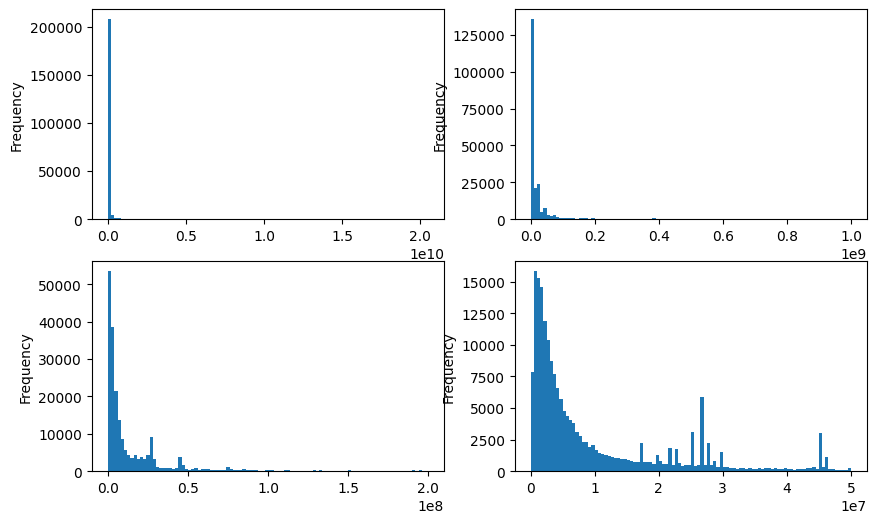

In [24]:
fig3, axs = plt.subplots(2, 2, figsize=(10, 6))

df8 = cart_data[cart_data['payable_price'] > 0]

df8['payable_price'].plot(kind='hist', bins=100, ax=axs[0][0])
df8[df8['payable_price'] < 1000000000]['payable_price'].plot(kind='hist', bins=100, ax=axs[0][1])
df8[df8['payable_price'] < 200000000]['payable_price'].plot(kind='hist', bins=100, ax=axs[1][0])
df8[df8['payable_price'] < 50000000]['payable_price'].plot(kind='hist', bins=100, ax=axs[1][1])

In [14]:
df9 = cart_data.copy()


def platform(source: str):
    if source == 'web' or source == 'mobile':
        return 'web'
    return 'app'


df9['platform'] = df9['source'].apply(lambda x: platform(x))
df9['closed_platform'] = df9['source_close'].apply(lambda x: platform(x))
df9 = pd.merge(left=df9, right=df7, left_on='id', right_on='cart_id')

In [23]:
grouped_df9 = df9.groupby(["cur_page", "next_page", "platform"])['cart_id'].count().reset_index()
grouped_df9.rename(columns={"cart_id": "count"}, inplace=True)
grouped_df9.sort_values(by=['cur_page', 'next_page', 'count'], ascending=False, inplace=True)
grouped_df9['percentage'] = grouped_df9['count'] / grouped_df9.groupby(['cur_page', 'platform'])['count'].transform(
    'sum') * 100

In [24]:
grouped_df9.pivot(index=['cur_page', 'platform'], columns='next_page', values='percentage').fillna(0)

next_page               "cart"  "checkout"  "payment"  "shipping"
cur_page   platform                                              
"cart"     app        0.748432    0.018728   0.404064   98.828776
           web        0.254132    0.094153   0.526616   99.125099
"checkout" app        0.265252    2.122016  92.838196    4.774536
           web        2.500000    0.500000  79.500000   17.500000
"payment"  app       19.702972   70.710104   0.021964    9.564960
           web        8.210605   75.255505   0.043780   16.490110
"shipping" app       39.705608    0.119493  59.629944    0.544955
           web       45.992740    0.061005  53.509688    0.436566

In [7]:
df6

,cart_id,changed_at,funnel_step,page,prev_changed_at,minutes_spent
215407,24031146,2023-09-10 13:54:36,"""cart""","""shipping""",2023-09-10 13:45:31,9.083333
215251,24031146,2023-09-10 13:54:44,"""shipping""","""cart""",2023-09-10 13:54:36,0.133333
214135,24031146,2023-09-10 13:55:58,"""cart""","""shipping""",2023-09-10 13:54:44,1.233333
214134,24031146,2023-09-10 13:55:59,"""shipping""","""cart""",2023-09-10 13:55:58,0.016667
213510,24031146,2023-09-10 13:56:39,"""cart""","""shipping""",2023-09-10 13:55:59,0.666667
...,...,...,...,...,...,...
266,350233608,2023-09-10 18:05:33,"""shipping""","""cart""",2023-09-10 18:05:25,0.133333
69,350233613,2023-09-10 18:05:48,"""shipping""","""cart""",2023-09-10 18:05:28,0.333333
165,350233622,2023-09-10 18:05:41,"""shipping""","""cart""",2023-09-10 18:05:33,0.133333
129,350233622,2023-09-10 18:05:43,"""payment""","""shipping""",2023-09-10 18:05:41,0.033333


In [8]:
df10 = df6[df6['minutes_spent'] > 10].copy()
df10.rename(columns={"page": "cur_page", "funnel_step": "next_page"}, inplace=True)
grouped_df10 = df10.groupby(["cur_page", "next_page"])['cart_id'].count().reset_index()
grouped_df10.rename(columns={"cart_id": "count"}, inplace=True)
grouped_df10.sort_values(by=['cur_page', 'next_page', 'count'], ascending=False, inplace=True)
grouped_df10['percentage'] = grouped_df10['count'] / grouped_df10.groupby('cur_page')['count'].transform('sum') * 100

In [41]:
grouped_df10.pivot(index='cur_page', columns='next_page', values='percentage').fillna(0)

next_page,"""cart""","""checkout""","""payment""","""shipping"""
cur_page,,,,
"""cart""",0.925423,0.132696,0.822024,98.119857
"""checkout""",0.666667,1.000000,85.000000,13.333333
"""payment""",8.604549,79.082864,0.051196,12.261391
"""shipping""",38.758880,0.154199,60.365583,0.721339


In [8]:
df11 = df6.copy()
df11

,cart_id,changed_at,funnel_step,page,prev_changed_at,minutes_spent
701173,24031146,2023-09-10 13:54:36,"""cart""","""shipping""",2023-09-10 13:45:31,9.083333
701017,24031146,2023-09-10 13:54:44,"""shipping""","""cart""",2023-09-10 13:54:36,0.133333
699901,24031146,2023-09-10 13:55:58,"""cart""","""shipping""",2023-09-10 13:54:44,1.233333
699900,24031146,2023-09-10 13:55:59,"""shipping""","""cart""",2023-09-10 13:55:58,0.016667
699276,24031146,2023-09-10 13:56:39,"""cart""","""shipping""",2023-09-10 13:55:59,0.666667
...,...,...,...,...,...,...
177,350319951,2023-09-11 10:12:13,"""shipping""","""cart""",2023-09-11 10:11:59,0.233333
112,350319975,2023-09-11 10:12:20,"""shipping""","""cart""",2023-09-11 10:12:14,0.100000
38,350319975,2023-09-11 10:12:28,"""cart""","""shipping""",2023-09-11 10:12:20,0.133333
13,350319979,2023-09-11 10:12:30,"""shipping""","""cart""",2023-09-11 10:12:17,0.216667


In [16]:
df11['churned'] = df11['minutes_spent'] > 10
df11.rename(columns={"page": "cur_page", "funnel_step": "next_page"}, inplace=True)
grouped_df11 = df11.groupby(["cur_page", "next_page", "churned"])['cart_id'].count().reset_index()
grouped_df11.rename(columns={"cart_id": "count"}, inplace=True)
# grouped_df11.sort_values(by=['cur_page', 'next_page', 'count'], ascending=False, inplace=True)
# grouped_df11['percentage'] = grouped_df11['count'] / grouped_df10.groupby('cur_page')['count'].transform('sum') * 100

In [17]:
df12 = df9.copy()
df12

,id,status,payable_price,source,source_close,platform,closed_platform,cart_id,changed_at,next_page,cur_page,funnel_step_change
0,349826242,closed,7865000,mobile,mobile,web,web,349826242,2023-09-08 01:43:53,"""shipping""","""cart""","""cart""->""shipping"""
1,349826242,closed,7865000,mobile,mobile,web,web,349826242,2023-09-08 01:44:43,"""payment""","""shipping""","""shipping""->""payment"""
2,349826242,closed,7865000,mobile,mobile,web,web,349826242,2023-09-08 01:44:46,"""checkout""","""payment""","""payment""->""checkout"""
3,349826244,closed,4852800,web,mobile,web,web,349826244,2023-09-08 21:12:42,"""shipping""","""cart""","""cart""->""shipping"""
4,349826244,closed,4852800,web,mobile,web,web,349826244,2023-09-08 21:12:58,"""cart""","""shipping""","""shipping""->""cart"""
...,...,...,...,...,...,...,...,...,...,...,...,...
833796,350319951,open,1970000,android,None,app,app,350319951,2023-09-11 10:12:13,"""shipping""","""cart""","""cart""->""shipping"""
833797,350319975,open,308554000,web,None,web,app,350319975,2023-09-11 10:12:20,"""shipping""","""cart""","""cart""->""shipping"""
833798,350319975,open,308554000,web,None,web,app,350319975,2023-09-11 10:12:28,"""cart""","""shipping""","""shipping""->""cart"""
833799,350319979,closed,4970000,android,android,app,app,350319979,2023-09-11 10:12:30,"""shipping""","""cart""","""cart""->""shipping"""


In [ ]:
df12['page'] = df12.groupby('cart_id')['funnel_step'].shift(1)
df12['prev_changed_at'] = df12.groupby('cart_id')['changed_at'].shift(1)
df12['minutes_spent'] = (df12['changed_at'] - df12['prev_changed_at']).dt.total_seconds() / 60